In [1]:
# Install dependencies first, then restart the kernel.
%pip install nltk
%pip install scikit-learn
%pip install matplotlib
%pip install beautifulsoup4


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from copy import copy
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup, Tag, Comment
import xml.dom.minidom
from xml.dom.minidom import Document
import re

def convert_to_element(tag):
    if isinstance(tag, Tag):
        element = ET.Element(tag.name, tag.attrs)
        for child in tag.contents:
            if isinstance(child, Tag):
                sub_element = convert_to_element(child)
                element.append(sub_element)
            else:
                element.text = child
        return element
    else:
        return ET.Element(tag)

def extract_body(html):
    html = re.sub("\s{2,}", "", html)
    soup = BeautifulSoup(html, 'html.parser')

    # Remove whitespace nodes
    def remove_whitespace_nodes(node):
        if not isinstance(node, str):
            for child in node.contents:
                if isinstance(child, str) and len(child.strip()) == 0:
                    child.extract()
                else:
                    remove_whitespace_nodes(child)

    remove_whitespace_nodes(soup)

    # Remove script tags (JavaScript)
    for script in soup.find_all('script'):
        script.extract()
    for script in soup.find_all('noscript'):
        script.extract()

    # Remove style tags (CSS)
    for style in soup.find_all('style'):
        style.extract()

    # Remove comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for comment in comments:
        comment.extract()
    
    # Remove SVG images because these have complex
    # drawing paths that we are not interested in
    for style in soup.find_all('svg'):
        style.extract()

    # For the same reason, discard Form and Input elements.
    for style in soup.find_all('form'):
        style.extract()
    for style in soup.find_all('input'):
        style.extract()

    # Extract body
    body = copy(soup.body)

    # Remove "class" attributes from all elements
    def remove_class_attributes(tag):
        #if tag.has_attr('class'):
        #    del tag['class']
        
        # Also remove data- attributes
        # and aria-, style CSS, IDs, and other noisy
        # attributes.
        for attr in list(tag.attrs):
            if not attr in ["alt", "title", "src", "href"]:
                del tag[attr]

            # Also remove empty keys
            elif tag[attr].strip() == "":
                del tag[attr]
            
        #    if attr.startswith('data-'):
        #        del tag[attr]
        #    elif attr.startswith('aria-'):
        #        del tag[attr]
        #    elif attr == 'style':
        #        del tag[attr]
        #    elif attr == 'id':
        #        del tag[attr]
        #    elif attr in ['height', 'loading', 'width', 'tabindex', 'dir', 'target', 'role', 'type']:
        #        del tag[attr]
        
        for child in tag.children:
            if isinstance(child, Tag):
                remove_class_attributes(child)

    remove_class_attributes(body)

    # Remove empty nodes
    def remove_empty_nodes(tag):
        children = tag.contents
        for child in children:
            if isinstance(child, Tag):
                if len(child.contents) > 0:
                    remove_empty_nodes(child)
                if len(child.contents) == 0 and len(child.attrs.keys()) == 0:
                    child.extract()

    remove_empty_nodes(body)

    def collapse_element(element):
        if len(element.contents) == 1 and isinstance(element.contents[0], Tag):
            child = element.contents[0]
            element.replace_with(child)

    # Recursively collapse elements
    def process_element(element):
        for child in element.children:
            if isinstance(child, Tag):
                process_element(child)
                collapse_element(child)

    process_element(body)
    title = soup.new_tag('title')
    title.string = soup.title.text
    body.insert(0, title)
    
    # Convert body contents to XML
    xml = str(body)

    return xml


## Example usage of the extraction

In [4]:
html = '''
<html>
<head>
    <title>Example HTML</title>
    <style>
        body {
            background-color: #f0f0f0;
        }
    </style>
</head>
<body>
    <h1 class="heading">Hello, world!</h1>
        <h2>
            <h3>
            <h4>Hello (again)</h4>
            </h3>
        </h2>
    <p>This is an example HTML.</p>
    <div class="container" data-info="some-info" data-value="42">
        <p class="info">Some information</p>
        <p class="note">A note</p>
    </div><div><div><div></div></div></div>
    </div><div><div><div>Nested content</div></div></div>
    <script>
        alert('This is JavaScript');
    </script>
</body>
</html>
'''

xml_output = re.sub('>\n+<', '><', extract_body(html))


dom = xml.dom.minidom.parseString(xml_output)
formatted_xml = dom.toprettyxml(indent='  ')

print(formatted_xml) #TODO Inspect - this is  not folding properly.

<?xml version="1.0" ?>
<body>
  <title>Example HTML</title>
  <h1>Hello, world!</h1>
  <h4>Hello (again)</h4>
  <p>This is an example HTML.</p>
  <div>
    <p>Some information</p>
    <p>A note</p>
  </div>
  <div>Nested content</div>
</body>



# Sample Yahoo Site Data starts here.

We are going to use this as a starting point to process all the other HTML data that we downloaded as part of the dataset, into a "clean" representation which can then be converted into a tokenized representation for Machine Learning, or it can be coupled with other cross-domain data using a Template Rule.

In [5]:
with open("../data/yahoo.com.html") as f:
    yahoo_html = f.read()

xml_output = extract_body(yahoo_html)
#print(xml_output[335671-100:335671+100])

dom = xml.dom.minidom.parseString(xml_output)
formatted_xml = dom.toprettyxml(indent='  ')
saved_xml = dom.toxml()

#print(formatted_xml)

# Data Tokenization

To tokenize the XML content into words using the xml.dom.minidom module, you can extract the text content from the DOM nodes and then tokenize the text using appropriate techniques. 

## Punkt tokenizer

The Punkt tokenizer is a pre-trained unsupervised machine learning tokenizer available in the NLTK (Natural Language Toolkit) library. It is designed specifically for tokenizing natural language text, capable of handling various punctuation patterns and ambiguous word boundaries. It uses a combination of unsupervised and supervised learning techniques to determine sentence boundaries and word tokenization, and has been trained on large corpora and can handle a wide range of languages and text genres.

Punkt is a widely used and reliable tool for tokenizing natural language text in many NLP (Natural Language Processing) tasks, including text analysis, information retrieval, and machine learning algorithms that require tokenized input, but it must be downloaded first:

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Code for tokenizing the XML
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def extract_text_from_tags(dom):
    body_text = ''
    h1_text = ''
    h2_text = ''
    h3_text = ''
    h4_text = ''
    h5_text = ''
    h6_text = ''
    other_text = ''

    def extract_text(node, header_level=-1):
        nonlocal body_text, h1_text, h2_text, h3_text, h4_text, h5_text, h6_text, other_text

        if node.nodeType == node.TEXT_NODE:
            if header_level == 0:
                body_text += ' ' + node.data.strip()
            elif header_level == 1:
                h1_text += ' ' + node.data.strip()
            elif header_level == 2:
                h2_text += ' ' + node.data.strip()
            elif header_level == 3:
                h3_text += ' ' + node.data.strip()
            elif header_level == 4:
                h4_text += ' ' + node.data.strip()
            elif header_level == 5:
                h5_text += ' ' + node.data.strip()
            elif header_level == 6:
                h6_text += ' ' + node.data.strip()
            else:
                other_text += ' ' + node.data.strip()
        elif node.nodeType == node.ELEMENT_NODE:
            if node.tagName == 'img':
                if node.hasAttribute('alt'):
                    if header_level == 0:
                        body_text += ' ' + node.getAttribute('alt')
                    elif header_level == 1:
                        h1_text += ' ' + node.getAttribute('alt')
                    elif header_level == 2:
                        h2_text += ' ' + node.getAttribute('alt')
                    elif header_level == 3:
                        h3_text += ' ' + node.getAttribute('alt')
                    elif header_level == 4:
                        h4_text += ' ' + node.getAttribute('alt')
                    elif header_level == 5:
                        h5_text += ' ' + node.getAttribute('alt')
                    elif header_level == 6:
                        h6_text += ' ' + node.getAttribute('alt')
                    else:
                        other_text += ' ' + node.getAttribute('alt')
            if node.hasAttribute('title'):
                if header_level == 0:
                    body_text += ' ' + node.getAttribute('title')
                elif header_level == 1:
                    h1_text += ' ' + node.getAttribute('title')
                elif header_level == 2:
                    h2_text += ' ' + node.getAttribute('title')
                elif header_level == 3:
                    h3_text += ' ' + node.getAttribute('title')
                elif header_level == 4:
                    h4_text += ' ' + node.getAttribute('title')
                elif header_level == 5:
                    h5_text += ' ' + node.getAttribute('title')
                elif header_level == 6:
                    h6_text += ' ' + node.getAttribute('title')
                else:
                    other_text += ' ' + node.getAttribute('title')

            for child in node.childNodes:
                extract_text(child, header_level)

    body = dom.documentElement
    for child in body.childNodes:
        if child.nodeType == child.ELEMENT_NODE:
            tag_name = child.tagName.lower()
            if tag_name == 'title':
                extract_text(child, 0)
            elif tag_name == 'h1':
                extract_text(child, 1)
            elif tag_name == 'h2':
                extract_text(child, 2)
            elif tag_name == 'h3':
                extract_text(child, 3)
            elif tag_name == 'h4':
                extract_text(child, 4)
            elif tag_name == 'h5':
                extract_text(child, 5)
            elif tag_name == 'h6':
                extract_text(child, 6)
            else:
                extract_text(child)

    return ' '.join([body_text.strip(), h1_text.strip(), h2_text.strip(), h3_text.strip(), h4_text.strip(),
                     h5_text.strip(), h6_text.strip(), other_text.strip()])

tokenized_text = nltk.word_tokenize(extract_text_from_tags(dom))
# Remove tokens with symbols using regular expressions
tokenized_text = [token for token in tokenized_text if re.match(r'^[-a-zA-Z0-9]+$', token)]

# Remove tokens that are entirely numbers
tokenized_text = [token for token in tokenized_text if not token.isdigit()]

# Remove tokens that are one character long
tokenized_text = [token for token in tokenized_text if len(token) > 1]

# Define common stopwords/conjunctions/pronouns
stopwords_list = set(stopwords.words('english'))

# Remove common stopwords
tokenized_text = [token for token in tokenized_text if token.lower() not in stopwords_list]

# Convert titlecase tokens to lowercase, except for ALL CAPS tokens
tokenized_text = [token.lower() if not token.isupper() else token for token in tokenized_text]

# And finally remove the website name from the list of tokens
website_name = "yahoo"
tokenized_text = [token for token in tokenized_text if token != website_name]

# Token weights

Next we are going to prepare the vectorizers by inserting more tokens based on how close to the beginning of the list the token is.

We will use an exponential distriution with $\lambda = t_I$ with $t_I$ representing the number of tokens at the beginning of the list that are interesting (and to be boosted). $t_I$ will be hardcoded to $min(\frac{t}{10}, 25)$ in all training data, where $t$ is the total number of tokens. This is to accomodate small webpages with small token lists close to $25$.

Consequentially we are going to use as our horizontal scaling (expanding specifically) factor $\frac{1}{\lambda^{2}}$.

In [8]:
import numpy as np

def flatten(l):
    return [item for sublist in l for item in sublist]

tokens = len(tokenized_text)
interesting_tokens = min(tokens/10, 25)
lam = interesting_tokens
tokenized_text_lists=[]
for i in range(0, len(tokenized_text)):
    x = i+1 # Make it one-based
    
    # Fractional additions are not possible so just truncate the addition number to an integer,
    # discarding the decimal place.
    y = int(lam * np.exp(-lam * 1/(interesting_tokens**2)*x) + 1)
    tokenized_text_lists.append([tokenized_text[i]]*y)
tokenized_text_2 = flatten(tokenized_text_lists)
tokenized_text = tokenized_text_2
del tokenized_text_2

## Token vectorizers

At this point, we have a choice between two machine learning algorithms for classifying the data - we can use Bag of Words which just counts the frequency of the terms in the documet, or we can use TF/IDF which stands for *Term Frequency times the Inverse Document Frequency* (the "IDF" being the *inverse* of the number of times the term appears in the document).

TF/IDF is more readily compared between different documents and so this is the metric that we will settle with. We will consider only terms with a frequency of 0.1 or greater.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

threshold = 0.1
# Calculate TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([" ".join(tokenized_text)])

# Get top tokens according to the threshold and TF-IDF scores
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
input_data = [x for x in zip(feature_names_tfidf, tfidf.toarray()[0]) if x[1] >= threshold]
top_tokens_tfidf = sorted(input_data, key=lambda x: x[1], reverse=True)
print(f"\nTop tokens (TF-IDF):")
for token, score in top_tokens_tfidf:
    print(f"{token}: {score}")


Top tokens (TF-IDF):
sports: 0.4133369782963032
feedback: 0.3887335867310471
thanks: 0.3887335867310471
mail: 0.2607959505917151
news: 0.24111323733951023
finance: 0.22635120240035653
politics: 0.13777899276543443
weather: 0.1328583144523832
home: 0.12793763613933196
entertainment: 0.12301695782628072
trump: 0.12301695782628072
sign: 0.1180962795132295
search: 0.11317560120017826
make: 0.1033342445740758


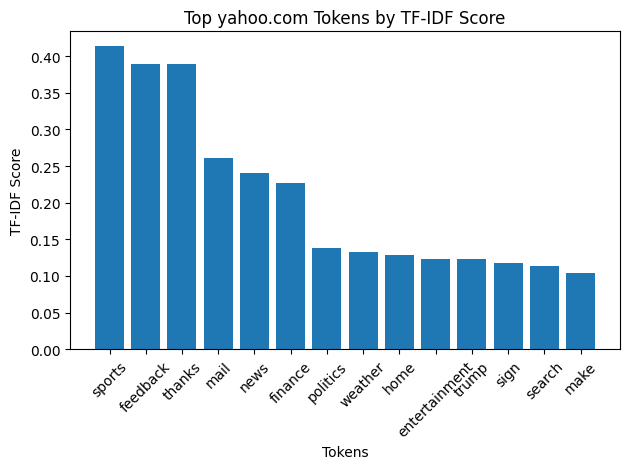

In [10]:
import matplotlib.pyplot as plt

# Extract tokens and scores in one line
tokens, scores = zip(*top_tokens_tfidf)

# Plot the TF-IDF scores
plt.bar(tokens, scores)
plt.xlabel('Tokens')
plt.ylabel('TF-IDF Score')
plt.title('Top yahoo.com Tokens by TF-IDF Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# One More Thing

We have to convert all this data into XML and export it into a file, together with their tokens and scores.

In [11]:
def generate_xml_file(xml_body, keys, values, version="1.0"):
    # Create the XML document
    xml_doc = Document()
    
    # Create the root element
    root = xml_doc.createElement("root")
    
    # Add the metadata section
    metadata = xml_doc.createElement("metadata")
    tags = xml_doc.createElement("tags")
    
    # Add the key-value pairs as tags
    for key, value in zip(keys, values):
        tag = xml_doc.createElement("tag")
        tag.setAttribute("key", key)
        tag.setAttribute("value", value)
        tags.appendChild(tag)
    
    metadata.appendChild(tags)
    root.appendChild(metadata)
    
    # Add the document section with the XML body
    document = xml_doc.createElement("document")
    document.appendChild(xml.dom.minidom.parseString(xml_body).documentElement)
    root.appendChild(document)
    
    # Set the XML version attribute
    xml_doc.appendChild(root)
    xml_doc.documentElement.setAttribute("version", version)
    
    # Write the XML document to a file
    with open('../outputs/yahoo.xml', 'w') as xml_file:
        xml_file.write(xml_doc.toxml())

generate_xml_file(saved_xml, [str(a) for a in tokens], [str(a) for a in scores])


# Finished

That's it! This is the demonstration to convert an HTML file into structured XML data.

A few noteworthy improvements can be made:

- Naturally, we need types to classify the TF/IDF most popular words with. Wikidata is a viable source. (Unfortunately I tried to download the dataset of words but the computer unexpectedly rebooted and now I must do it again.)
- We must be able to "figure out" what the site name is given the contents of the input HTML file. We can't just assume that it's going to be the name of the file, because many site names have two or more letters in them.
- Also we are going to be processing website files at scale, so it's worth looking into making this multithreaded. This must be done quickly so that Eclipse template-rules repository has input data ready to use.